In [3]:
import pandas as pd
import numpy as np
import joblib
import json
import tensorflow as tf
from tensorflow.keras.layers import Lambda
import os

# --- Definir la función de muestreo ---
# Keras necesita esta función disponible para poder reconstruir la capa Lambda del encoder.
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

print("Cargando los modelos y componentes...")

# --- Cargar todos los artefactos guardados ---
model_dir = 'modelos_desplegables'

try:
    # AÑADIMOS 'custom_objects' PARA QUE KERAS ENCUENTRE LA FUNCIÓN 'sampling'
    encoder = tf.keras.models.load_model(
        os.path.join(model_dir, 'encoder_model.keras'),
        custom_objects={'sampling': sampling}
    )
    
    xgb_model = joblib.load(os.path.join(model_dir, 'xgb_augmented_model.joblib'))
    scaler = joblib.load(os.path.join(model_dir, 'scaler.joblib'))

    with open(os.path.join(model_dir, 'config.json'), 'r') as f:
        config = json.load(f)
    features = config['features']
    
    print("Modelos y componentes cargados exitosamente. ✅")

except FileNotFoundError as e:
    print(f"🚨 Error: No se encontró el archivo '{e.filename}'.")
    print("Asegúrate de haber ejecutado primero la celda para guardar los modelos en tu cuaderno de entrenamiento.")
except Exception as e:
    print(f"🚨 Ocurrió un error al cargar los modelos: {e}")

Cargando los modelos y componentes...
Modelos y componentes cargados exitosamente. ✅


In [4]:
def predecir_anomalia(declaracion_dict):
    """
    Toma una declaración como un diccionario de Python, la procesa
    y devuelve la predicción del modelo híbrido.
    """
    try:
        # Convertir el diccionario a un DataFrame de una sola fila
        df_nuevo = pd.DataFrame([declaracion_dict])
        
        # Asegurarse de que el DataFrame tenga todas las características necesarias, en el orden correcto
        X_nuevo = df_nuevo[features]
        
        # 1. Escalar los datos con el MISMO scaler del entrenamiento
        X_nuevo_scaled = scaler.transform(X_nuevo)
        
        # 2. Extraer características latentes con el encoder
        z_mean, _, _ = encoder.predict(X_nuevo_scaled, verbose=0) # verbose=0 para una salida limpia
        
        # 3. Crear el set de datos "aumentado"
        X_nuevo_augmented = np.concatenate([X_nuevo_scaled, z_mean], axis=1)
        
        # 4. Hacer la predicción con XGBoost
        prediccion = xgb_model.predict(X_nuevo_augmented)
        probabilidad = xgb_model.predict_proba(X_nuevo_augmented)
        
        return {
            'prediccion': int(prediccion[0]), # 0 para Normal, 1 para Anomalía
            'probabilidad_anomalia': float(probabilidad[0][1])
        }
    except NameError:
        print("🚨 Error: Parece que los modelos no se han cargado. Ejecuta la celda 1 primero.")
        return None
    except Exception as e:
        print(f"🚨 Ocurrió un error durante la predicción: {e}")
        return None

In [15]:
# Simulemos una nueva declaración para predecir (puedes cambiar estos valores)
# Escenario 1: Una declaración que debería ser anómala (activos muy altos vs ingreso)
declaracion_anomala = {
    'ingreso_anual_neto_total': 350000.0,
    'sueldo_anual_publico': 350000.0,
    'otros_ingresos_anuales': 0.0,
    'valor_total_activos': 15000000.0, # Valor desproporcionado
    'valor_total_deuda': 50000.0,
    'conteo_inmuebles': 3,
    'conteo_vehiculos': 2,
    'conteo_inversiones': 1
}

# Escenario 2: Una declaración que parece normal
declaracion_normal = {
    'ingreso_anual_neto_total': 450000.0,
    'sueldo_anual_publico': 450000.0,
    'otros_ingresos_anuales': 0.0,
    'valor_total_activos': 800000.0,
    'valor_total_deuda': 250000.0,
    'conteo_inmuebles': 1,
    'conteo_vehiculos': 1,
    'conteo_inversiones': 0
}


# --- Realizar y mostrar la predicción para el primer escenario ---
print("--- Analizando Escenario 1 (Declaración Anómala) ---")
resultado_1 = predecir_anomalia(declaracion_anomala)

if resultado_1:
    if resultado_1['prediccion'] == 1:
        print(f"Resultado: 🚨 POSIBLE ANOMALÍA DETECTADA")
    else:
        print(f"Resultado: ✅ Declaración Normal")
    print(f"Probabilidad de ser anomalía: {resultado_1['probabilidad_anomalia']:.2%}")


# --- Realizar y mostrar la predicción para el segundo escenario ---
print("\n--- Analizando Escenario 2 (Declaración Normal) ---")
resultado_2 = predecir_anomalia(declaracion_normal)

if resultado_2:
    if resultado_2['prediccion'] == 1:
        print(f"Resultado: 🚨 POSIBLE ANOMALÍA DETECTADA")
    else:
        print(f"Resultado: ✅ Declaración Normal")
    print(f"Probabilidad de ser anomalía: {resultado_2['probabilidad_anomalia']:.2%}")

--- Analizando Escenario 1 (Declaración Anómala) ---
Resultado: 🚨 POSIBLE ANOMALÍA DETECTADA
Probabilidad de ser anomalía: 100.00%

--- Analizando Escenario 2 (Declaración Normal) ---
Resultado: ✅ Declaración Normal
Probabilidad de ser anomalía: 0.09%


# Prueba con dataset de Jalisco

In [16]:
# --- Carga y Preparación de Datos ---
print("Cargando el dataset de Jalisco...")
df = pd.read_parquet('./datasets/declaraciones_procesadas_jalisco.parquet', engine='fastparquet')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

# Convertir la columna de fecha para poder ordenarla
df['fecha_actualizacion'] = pd.to_datetime(df['fecha_actualizacion'])

# ============================================================
# PARTE 1: SCRIPT DE ETIQUETADO BASADO EN REGLAS DE NEGOCIO
# ============================================================

df = df[(df["sueldo_anual_publico"] != 0)]
print("\nIniciando etiquetado de anomalías según el manual de verificación...")

# --- Regla 1: Ingreso Anual Neto Excesivo ---
umbral_ingreso = 2_000_000
df['anomalia_ingreso'] = df['ingreso_anual_neto_total'] > umbral_ingreso

# --- Regla 2: Discrepancia Activos vs. Ingresos ---
# Se considera anomalía si los activos son más de 5 veces el ingreso,
# y el ingreso no es cero para evitar divisiones infinitas.
multiplo_activos = 5
df['anomalia_discrepancia_activos'] = (
    (df['valor_total_activos'] > (df['ingreso_anual_neto_total'] * multiplo_activos)) &
    (df['ingreso_anual_neto_total'] > 0)
)

# --- Regla 3: Aumento Súbito de Activos (Análisis Histórico) ---
df = df.sort_values(by=['nombre_completo', 'fecha_actualizacion'])
# Calculamos la diferencia de activos con respecto a la declaración anterior del mismo funcionario
df['activos_previos'] = df.groupby('nombre_completo')['valor_total_activos'].shift(1)
df['aumento_activos'] = df['valor_total_activos'] - df['activos_previos']

# Umbral de aumento súbito (ej. un aumento de más de $1,000,000 en un año)
umbral_aumento = 1_000_000
df['anomalia_aumento_subito'] = (df['aumento_activos'] > umbral_aumento) & (df['activos_previos'].notna())

# --- Etiqueta Final: 'posible_anomalia' ---
# Una declaración se marca como anómala si cumple CUALQUIERA de las reglas.
df['posible_anomalia'] = (
    df['anomalia_ingreso'] |
    df['anomalia_discrepancia_activos'] |
    df['anomalia_aumento_subito']
).astype(int)

# --- Reporte del Etiquetado ---
total_anomalias = df['posible_anomalia'].sum()
porcentaje = (total_anomalias / len(df)) * 100

print(f"\nEtiquetado completado.")
print(f"Total de declaraciones marcadas como 'posible anomalía': {total_anomalias} ({porcentaje:.2f}%)")
print("\nDesglose de anomalías encontradas por regla:")
print(f"- Por Ingreso Excesivo: {df['anomalia_ingreso'].sum()}")
print(f"- Por Discrepancia Activos vs Ingreso: {df['anomalia_discrepancia_activos'].sum()}")
print(f"- Por Aumento Súbito de Activos: {df['anomalia_aumento_subito'].sum()}")

# Limpiamos columnas auxiliares
df = df.drop(columns=['anomalia_ingreso', 'anomalia_discrepancia_activos', 'anomalia_aumento_subito', 'activos_previos', 'aumento_activos'])

Cargando el dataset de Jalisco...
Dataset cargado con 525243 filas y 18 columnas.


C:\Users\sesea4\AppData\Local\Temp\ipykernel_20344\1544772649.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['fecha_actualizacion'] = pd.to_datetime(df['fecha_actualizacion'])



Iniciando etiquetado de anomalías según el manual de verificación...

Etiquetado completado.
Total de declaraciones marcadas como 'posible anomalía': 32679 (9.21%)

Desglose de anomalías encontradas por regla:
- Por Ingreso Excesivo: 28397
- Por Discrepancia Activos vs Ingreso: 3820
- Por Aumento Súbito de Activos: 1060


In [17]:
df

,id_declaracion,nombre_completo,nombre_archivo,fecha_actualizacion,ingreso_anual_neto_total,sueldo_anual_publico,otros_ingresos_anuales,valor_total_activos,valor_total_deuda,conteo_inmuebles,conteo_vehiculos,conteo_inversiones,conteo_adeudos,nivel_empleo,area_adscripcion,fecha_toma_posesion,tipo_declaracion,declaracion_completa,posible_anomalia
26901,6090b54b138c05da42f2a94a,,data-0000000135.json,2021-05-25 01:37:04+00:00,14338728,14338728.0,0,0,0,0,0,0,0,03,Delegación Regional De La Secretaría De Educac...,2018-05-16,MODIFICACIÓN,False,1
25755,6090b549138c05da42f258ce,,data-0000000129.json,2021-05-29 02:51:18+00:00,511907,511907.0,0,0,0,0,0,0,0,1,Antiguo Hospital Civil,2018-06-01,MODIFICACIÓN,False,0
202904,627026d0be384b0ee423dfe8,,data-0000001015.json,2022-05-11 04:25:10+00:00,140944,140944.0,0,0,0,0,0,0,0,1,Dirección De Educación Primaria,1997-11-01,MODIFICACIÓN,False,0
234043,6270278abe384b0ee427bd1b,,data-0000001171.json,2022-05-13 22:06:45+00:00,144043,144043.0,0,0,0,0,0,0,0,2,OFICINA DE RECAUDACION FISCAL NUMERO 02,2021-05-01,MODIFICACIÓN,False,0
188808,62702685be384b0ee4225148,,data-0000000945.json,2022-05-14 18:27:54+00:00,522530,522530.0,0,0,0,0,0,0,0,2,Área De Gestión Y Operación De Educación Primaria,1995-09-01,MODIFICACIÓN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310977,644f98860d836aea190aa11a,ÓSCAR ADRIAN AGUIRRE CEDEÑO,data-0000001555.json,2023-05-29 18:16:38+00:00,117132,117132.0,0,0,0,0,0,0,0,,Secretaría De Educación,2011-12-01,MODIFICACIÓN,False,0
469835,9bb819fa-8910-4cf8-a35a-fd4b1d795ec1,ÓSCAR ALEJANDRO FLORES BRISEÑO,data-0000002350.json,2022-05-31 00:00:00+00:00,133426,133426.0,0,0,0,0,0,0,0,2,SPUB-SEGURIDAD PUBLICA,2017-07-17,MODIFICACIÓN,False,0
32622,6090b5cd042e12dced7590a3,ÓSCAR RODRIGO ESTRELLA GONZALEZ,data-0000000164.json,2021-06-01 02:11:42+00:00,240912,240912.0,0,0,0,0,0,0,0,11,Dirección De Organización Territorial,2019-07-01,MODIFICACIÓN,False,0
156852,627025d3be384b0ee41d9682,ÓSCAR RODRIGO ESTRELLA GONZALEZ,data-0000000785.json,2022-05-04 17:30:07+00:00,212978,212978.0,0,0,0,0,0,0,0,11,Dirección De Organización Territorial,2019-07-01,MODIFICACIÓN,False,0


In [18]:
df = df[['ingreso_anual_neto_total', 'sueldo_anual_publico', 'otros_ingresos_anuales',
    'valor_total_activos', 'valor_total_deuda', 'conteo_inmuebles',
    'conteo_vehiculos', 'conteo_inversiones','posible_anomalia']]
df

,ingreso_anual_neto_total,sueldo_anual_publico,otros_ingresos_anuales,valor_total_activos,valor_total_deuda,conteo_inmuebles,conteo_vehiculos,conteo_inversiones,posible_anomalia
26901,14338728,14338728.0,0,0,0,0,0,0,1
25755,511907,511907.0,0,0,0,0,0,0,0
202904,140944,140944.0,0,0,0,0,0,0,0
234043,144043,144043.0,0,0,0,0,0,0,0
188808,522530,522530.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
310977,117132,117132.0,0,0,0,0,0,0,0
469835,133426,133426.0,0,0,0,0,0,0,0
32622,240912,240912.0,0,0,0,0,0,0,0
156852,212978,212978.0,0,0,0,0,0,0,0


In [22]:
fila = df.iloc[80].to_dict()
resultado = predecir_anomalia(fila)
print(fila)
print(resultado)

{'ingreso_anual_neto_total': 247160.0, 'sueldo_anual_publico': 247160.0, 'otros_ingresos_anuales': 0.0, 'valor_total_activos': 1739900.0, 'valor_total_deuda': 0.0, 'conteo_inmuebles': 1.0, 'conteo_vehiculos': 3.0, 'conteo_inversiones': 0.0, 'posible_anomalia': 1.0}
{'prediccion': 1, 'probabilidad_anomalia': 0.9988536834716797}


In [9]:
def predecir_anomalia_df(df_declaraciones):
    try:
        X_nuevo = df_declaraciones[features]
        X_nuevo_scaled = scaler.transform(X_nuevo)
        z_mean, _, _ = encoder.predict(X_nuevo_scaled, verbose=0)
        X_nuevo_augmented = np.concatenate([X_nuevo_scaled, z_mean], axis=1)
        
        predicciones = xgb_model.predict(X_nuevo_augmented)
        probabilidades = xgb_model.predict_proba(X_nuevo_augmented)
        
        return pd.DataFrame({
            'prediccion': predicciones.astype(int),
            'probabilidad_anomalia': probabilidades[:, 1].astype(float)
        })
    except Exception as e:
        print(f"🚨 Error durante la predicción: {e}")
        return None


In [40]:
df_resultados = predecir_anomalia_df(df)
#df_final = pd.concat([df, df_resultados], axis=1)
df_final = pd.concat([df.reset_index(drop=True), df_resultados.reset_index(drop=True)], axis=1)



📈 Evaluación del Modelo en el Dataset Nuevo
Accuracy:  0.987
Precision: 0.884
Recall:    0.992
F1 Score:  0.935
ROC AUC:   1.000


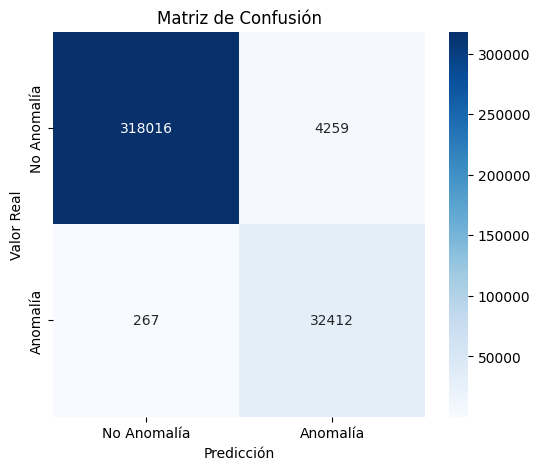

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Etiquetas verdaderas y predicciones del modelo
y_true = df_final['posible_anomalia']
y_pred = df_final['prediccion']
y_prob = df_final['probabilidad_anomalia']

# Métricas principales
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_prob)

print("📈 Evaluación del Modelo en el Dataset Nuevo")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
labels = ['No Anomalía', 'Anomalía']
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()


In [50]:
df_final[df_final['prediccion'] == 1]

,ingreso_anual_neto_total,sueldo_anual_publico,otros_ingresos_anuales,valor_total_activos,valor_total_deuda,conteo_inmuebles,conteo_vehiculos,conteo_inversiones,posible_anomalia,prediccion,probabilidad_anomalia
0,14338728,14338728.0,0,0,0,0,0,0,1,1,0.999958
6,6315408,6315408.0,0,0,0,0,0,0,1,1,0.999958
9,12123632,12123632.0,0,0,0,0,0,0,1,1,0.999958
16,57149042,57130322.0,18720,0,0,0,0,0,1,1,0.999979
18,19582272,19582272.0,0,0,0,0,0,0,1,1,0.999958
...,...,...,...,...,...,...,...,...,...,...,...
354851,16284010,16284010.0,0,0,0,0,0,0,1,1,0.999958
354871,18175194,18175194.0,0,0,0,0,0,0,1,1,0.999958
354873,25346563,25346563.0,0,0,0,0,0,0,1,1,0.999958
354874,25547866,25547866.0,0,0,0,0,0,0,1,1,0.999958
